In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [11]:
import spikeforest as sf
import spikeinterface.full as si
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.linear_model import LinearRegression
import yaml
from cdlgr.dataset.dataset import get_dataset
import notebook_helper as helper
import spikeinterface.qualitymetrics as qm


## Data overview



### Synthetic dataset

In [12]:
dataset_synth = helper.load_dataset("synth_default_dataset")

#### Signal visualization

Let's visualize the signal.

In [13]:
sw.plot_traces(dataset_synth.recording, time_range=[0, 10], backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [14]:
print("Y-scale present?", dataset_synth.recording.has_scaled())

Y-scale present? False


#### Denoising

In [15]:
print("Noise (median absolute deviation)", si.get_noise_levels(dataset_synth.recording, return_scaled=False, chunk_size=10000))

Noise (median absolute deviation) [0.10242041]


No common noise removal because only one channel.

#### Spectrogram and FFT

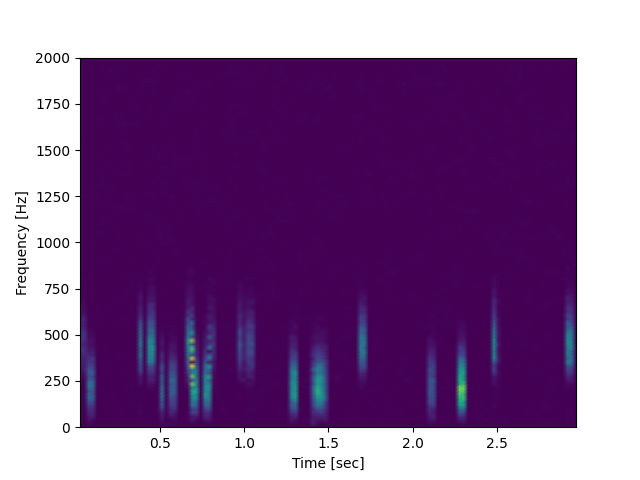

In [18]:
f, t, Sxx = helper.get_spectrogram(dataset_synth.recording, 30000)
plt.figure()
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 2000)
plt.show()

10000
(30000, 1) (30000,)


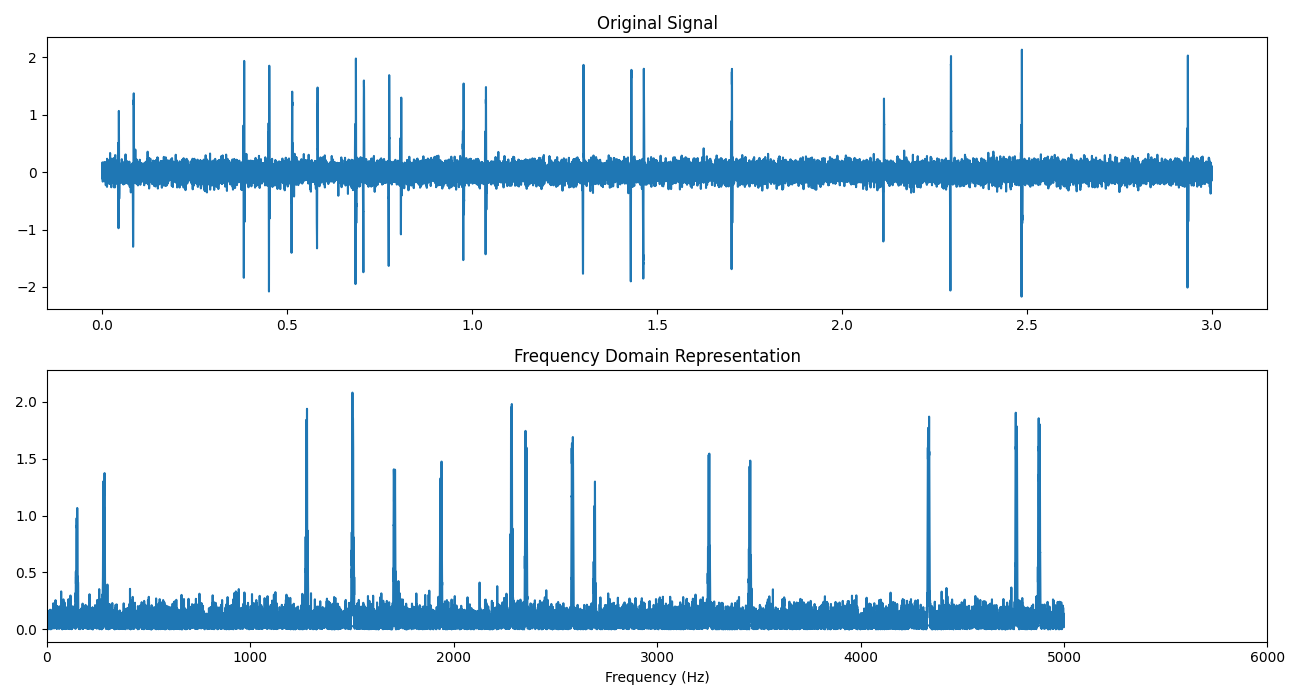

In [20]:
helper.fft_rec(dataset_synth.recording, 30000)

#### Waveforms

extract waveforms shared_memory multi buffer:   0%|          | 0/3 [00:00<?, ?it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:   0%|          | 0/3 [00:00<?, ?it/s]

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

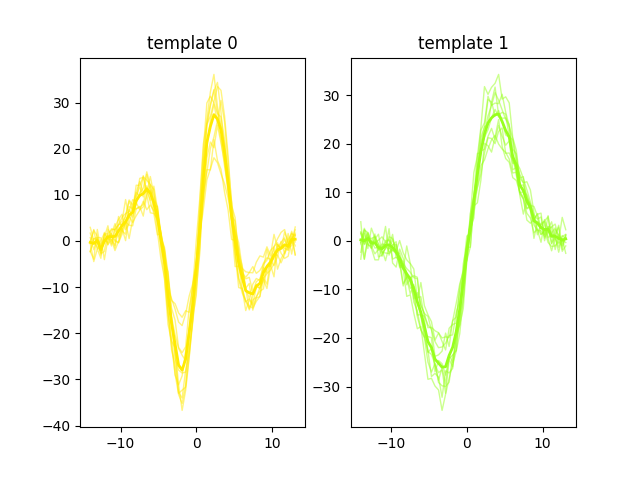

In [21]:
plt.close('all')
waveforms = si.extract_waveforms(dataset_synth.recording, dataset_synth.sorting_true, max_spikes_per_unit=2500, mode="memory", ms_before=3, ms_after=3)
w = sw.plot_spikes_on_traces(waveform_extractor=waveforms, backend="ipywidgets")
sw.plot_unit_waveforms(waveforms)

In [22]:
snrs = qm.compute_snrs(waveforms)
print("SNR (dB)", 20*np.log10(snrs[1]))

SNR (dB) 23.531372666551526



### Real dataset

First, we need to retrieve the dataset. Here we do not use the function we did so that we can understand the different operations performed.

In [23]:
dataset_real = helper.load_dataset("default_dataset")

You must have set up kachery-cloud (see [here](https://github.com/flatironinstitute/kachery-cloud?tab=readme-ov-file#installation-and-setup)).

In [24]:
sw.plot_traces(dataset_real.recording, time_range=[0, 10], channel_ids=[18],backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [25]:
print(dataset_real.recording.has_scaled())

False


No scaled traces so we cannot have a unit for the y-axis.

#### Stationarity and ergodicity

Given the many spikes, the signal is not stationary and ergodic, but it seems that the background noise is quite stationary over time, which would allow us some basic preprocessing. The use of the median instead of the mean for statistics will make us more robust towards the spiking outliers.

#### Denoising

In [26]:
print(si.get_noise_levels(dataset_real.recording, return_scaled=False, chunk_size=10000)[18])

38.54765768114565


In [27]:
recording_denoised = si.common_reference(dataset_real.recording, reference='global')
print(si.get_noise_levels(recording_denoised, return_scaled=False, chunk_size=10000)[18])

37.065055462640046


In [28]:
recording = recording_denoised.channel_slice([18])

#### Spectrogram and FFT

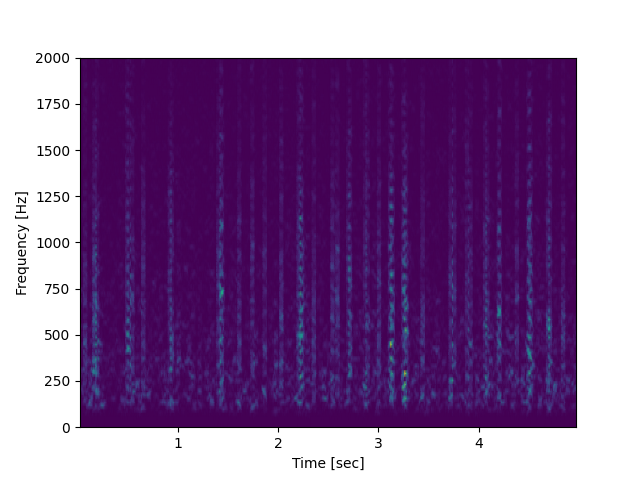

In [29]:
plt.close('all')
f, t, Sxx = signal.spectrogram(recording.get_traces(end_frame=100000).flatten(), recording.get_sampling_frequency(),
                               nperseg=1024, noverlap=1024 - 100, window=('tukey', 0.25))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 2000)
plt.show()

Even if the random peaks make the signal non stationary, it can be interesting to compute the FFT to check there is no systematic background noise like for instance some electric resonance around 60 Hz. We can use FFT because we assume there is no abrupt change in the timeseries, except spikes.

In [30]:
print(recording.is_filtered())

False


20000.0
(100000, 1) (100000,)


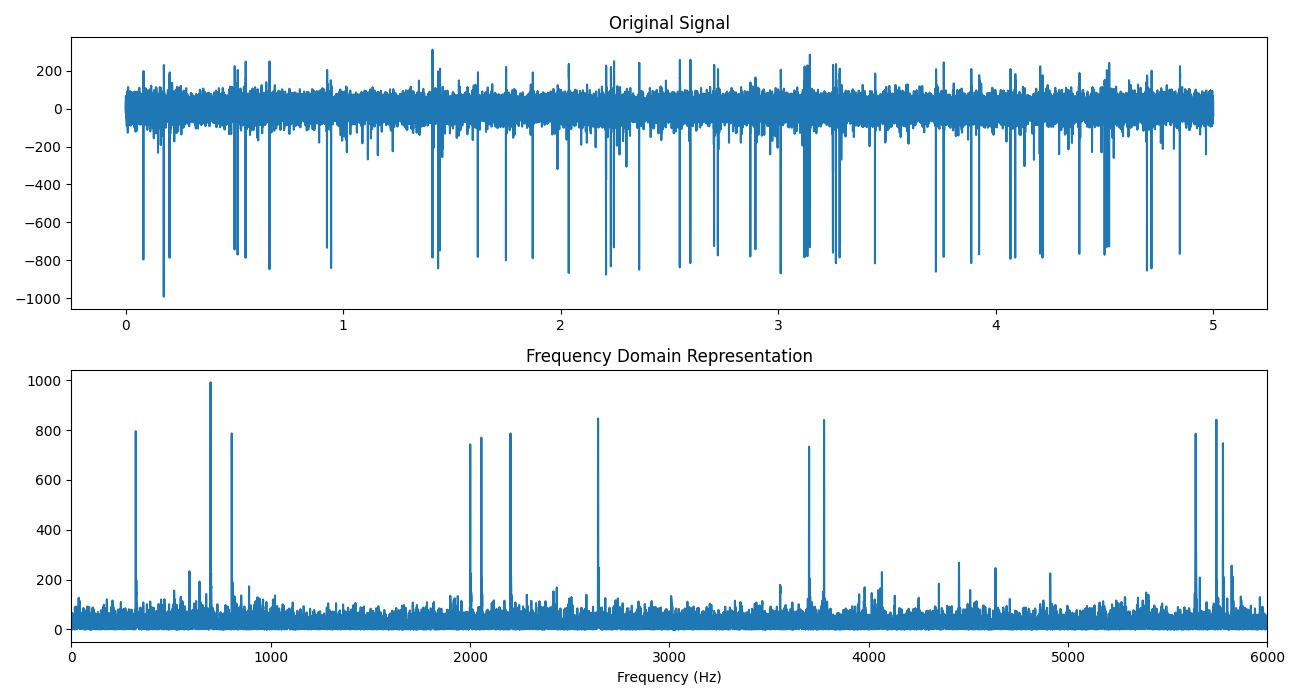

In [31]:
helper.fft_rec(recording)

We filter the signal to keep only the high-frequency components corresponding to the spikes.

20000.0
(100000, 1) (100000,)


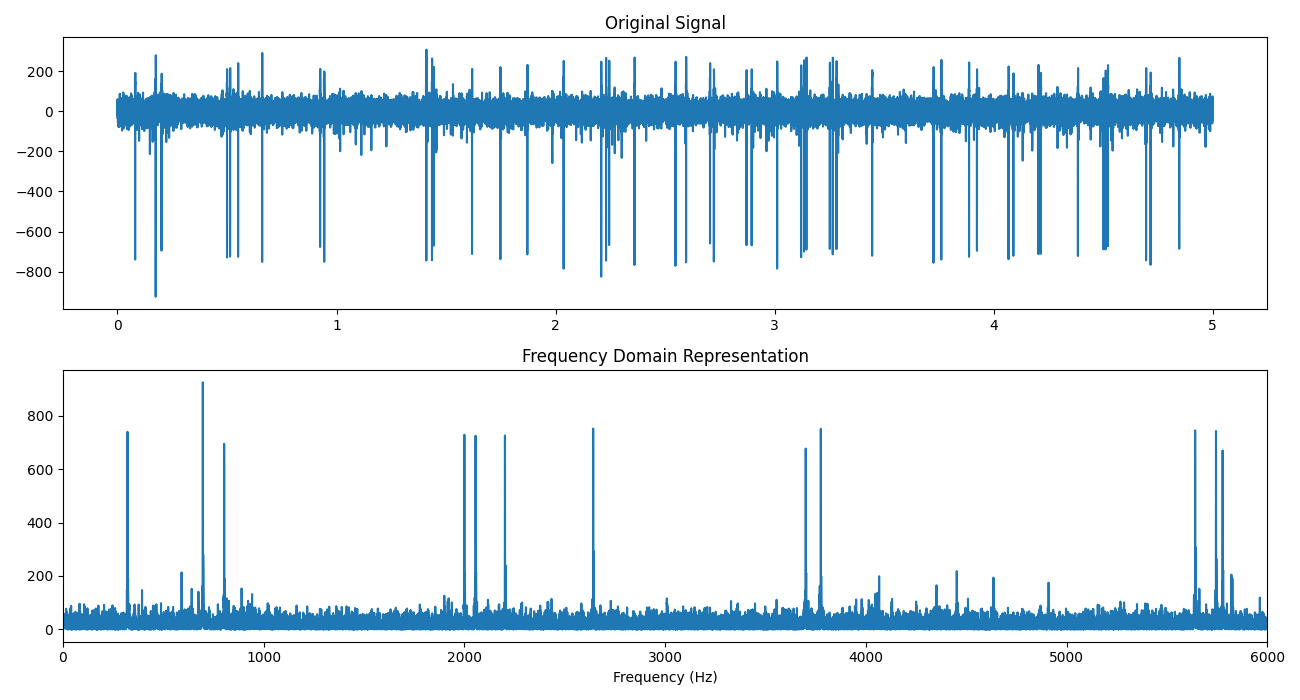

In [32]:
recording_filt = si.bandpass_filter(recording, 300, 6000)
helper.fft_rec(recording_filt)

In fact, contrary to what the recording object indicates, it has already been filtered.

In [33]:
recording.annotate(is_filtered=True)

Plotting autocorrelation does not make a lot of sense here.

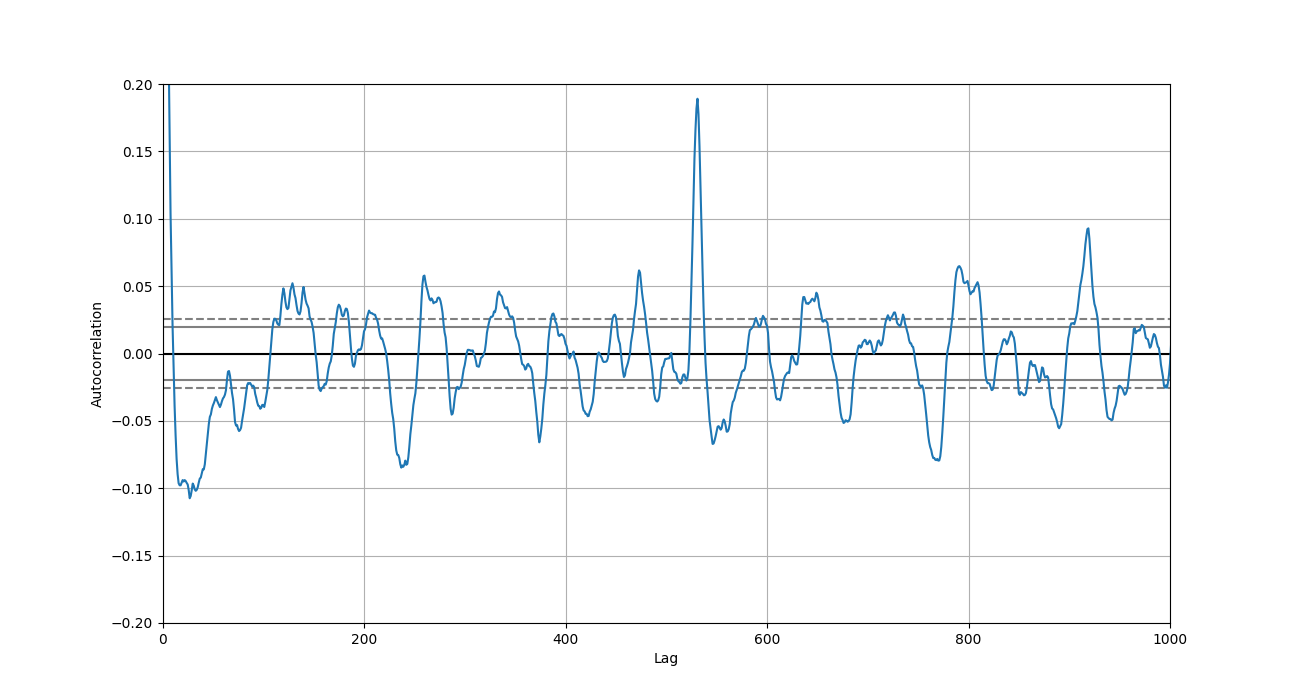

In [34]:
plt.figure(figsize=(13, 7))
pd.plotting.autocorrelation_plot(recording.get_traces(end_frame=10000))
plt.ylim(-0.2, 0.2)
plt.xlim(0, 1000)
plt.show()

#### Detrending

We check if there is no major trend in the signal, even though it does not seem so

Coefficients: [[-0.00093171]]


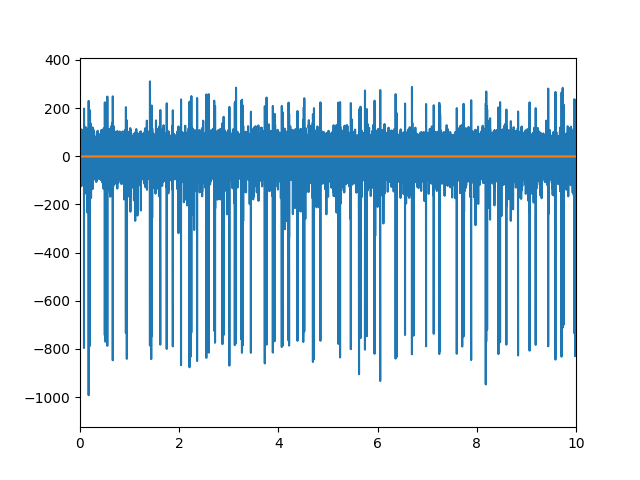

In [36]:
traces = recording.get_traces()
times = np.arange(len(traces)) / recording.get_sampling_frequency()
times = times.reshape((-1, 1))
model = LinearRegression()
model.fit(times, traces)
print('Coefficients: %s' % model.coef_)
# calculate trend
trend = model.predict(times)
# plot trend
plt.figure()
plt.plot(times, traces)
plt.plot(times, trend)
plt.xlim(0, 10)
plt.show()

#### Spikes waveforms

In [37]:
waveforms = si.extract_waveforms(recording, dataset_real.sorting_true, max_spikes_per_unit=2500, mode="memory")

extract waveforms shared_memory multi buffer:   0%|          | 0/100 [00:00<?, ?it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:   0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
w = sw.plot_spikes_on_traces(waveform_extractor=waveforms, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

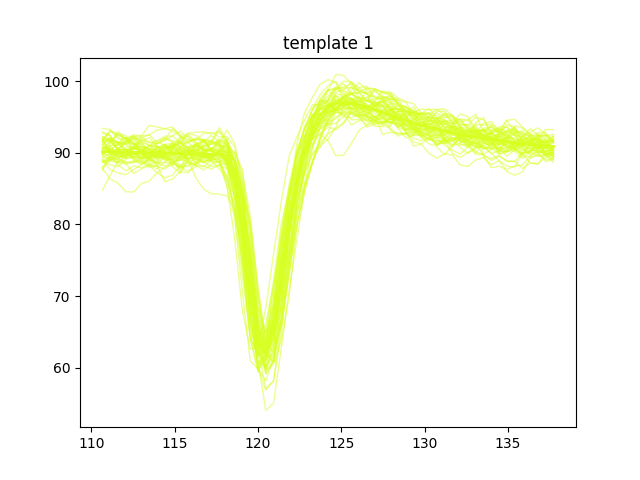

In [39]:
sw.plot_unit_waveforms(waveforms)

In [40]:
snrs = qm.compute_snrs(waveforms)
print("SNR (dB)", 20*np.log10(snrs[1]))

SNR (dB) 26.44732758005682


## Experiments

To run an experiment, you can run ``!ssrun [params]`` in a notebook cell. Available parameters are the following: [...]

### Synthetic dataset

In [ ]:
!ssrun dataset=synth_dataset_exp6 model=synth_model_exp6 experiment=6

In [ ]:
!ssrun hydra.mode=MULTIRUN dataset=synth_dataset model=synth_model model.cdl.interpolate=0,2 dataset.gen.seed=1 trial=range(1, 11)

### Real dataset

In [ ]:
!ssrun

^C


experiment: sandbox


extract waveforms shared_memory multi buffer:   0%|          | 0/10 [00:00<?, ?it/s]


extract waveforms shared_memory multi buffer:  30%|###       | 3/10 [00:00<00:00, 17.99it/s]

output:


  verbose: 1

extract waveforms shared_memory multi buffer:  50%|#####     | 5/10 [00:00<00:00, 16.51it/s]

  plot: 2

extract waveforms shared_memory multi buffer:  70%|#######   | 7/10 [00:00<00:00, 16.02it/s]

  preprocess:

extract waveforms shared_memory multi buffer:  90%|######### | 9/10 [00:00<00:00, 15.56it/s]


extract waveforms shared_memory multi buffer: 100%|##########| 10/10 [00:00<00:00, 15.04it/s]

    plot_traces: false

    plot_waveforms: false

extract waveforms shared_memory multi buffer:   0%|          | 0/10 [00:00<?, ?it/s]

    plot_snrs: false

extract waveforms shared_memory multi buffer:  30%|###       | 3/10 [00:00<00:00, 19.29it/s]

  fp_threshold_ms: 15

extract waveforms shared_memory multi buffer:  50%|#####     | 5/10 [00:00<00:00, 18.38it/s]

dataset:


extract waveforms shared_memory multi buffer:  70%|#######   | 7/10 [00:00<00:00, 18.12it/s]

  type: spikeforest

extract waveforms shared_memory multi buffer: 100%|##########| 10/10 [00:00<00:00, 18.39it/s]

  name: paired_mea64c


  recording: 20170622_patch2


detect peaks using by_channel:   0%|          | 0/10 [00:00<?, ?it/s]


detect peaks using by_channel:  20%|##        | 2/10 [00:00<00:00, 12.68it/s]

  uri: sha1://1d343ed7e876ffd73bd8e0daf3b8a2c4265b783c?spikeforest-recordings.json

detect peaks using by_channel:  40%|####      | 4/10 [00:00<00:00, 12.91it/s]

  tstart_s: 0

detect peaks using by_channel:  60%|######    | 6/10 [00:00<00:00, 13.00it/s]

  tstop_s: 10

detect peaks using by_channel:  80%|########  | 8/10 [00:00<00:00, 13.07it/s]

  tstart_test_s: null


  tstop_test_s: null

detect peaks using by_channel: 100%|##########| 10/10 [00:00<00:00, 13.11it/s]


  channel: 18

0it [00:00, ?it/s]


  preprocess: true

44it [00:00, 437.68it/s]


  preprocess_params:

90it [00:00, 442.95it/s]


    freq_min: 300


141it [00:00, 459.08it/s]

    freq_max: 6000

184it [00:00, 473.08it/s]

  window:

  0%|          | 0/184 [00:00<?, ?it/s]

    split: true

 10%|▉         | 18/184 [00:00<00:00, 179.74it/s]

    window_size_s: 0.0044

 18%|█▊        | 33/184 [00:00<00:00, 169.52it/s]

  gen:

 29%|██▉       | 54/184 [00:00<00:00, 179.29it/s]


    seed: null


 40%|████      | 74/184 [00:00<00:00, 184.63it/s]

model:


 50%|█████     | 92/184 [00:00<00:00, 180.07it/s]

  dictionary:

 59%|█████▊    | 108/184 [00:00<00:00, 167.26it/s]

    num_elements: 1

 69%|██████▉   | 127/184 [00:00<00:00, 169.71it/s]

    element_length_ms: 2.15

 80%|███████▉  | 147/184 [00:00<00:00, 176.55it/s]

    init_templates: signal


 89%|████████▉ | 164/184 [00:00<00:00, 163.65it/s]

  cdl:

 98%|█████████▊| 181/184 [00:01<00:00, 163.56it/s]


    num_iterations: 20


100%|██████████| 184/184 [00:01<00:00, 170.97it/s]


    interpolate: 10

  0%|          | 0/184 [00:00<?, ?it/s]

    sparsity_tol: 1


    sparsity_tol_test: 40

 11%|█         | 20/184 [00:00<00:00, 192.54it/s]



    rel_amp_split_test: 0.6

 23%|██▎       | 43/184 [00:00<00:00, 200.75it/s]



    error_tol: 0.01

 35%|███▌      | 65/184 [00:00<00:00, 205.70it/s]


 48%|████▊     | 88/184 [00:00<00:00, 210.80it/s]

    interpolator_type: sinc

 60%|██████    | 111/184 [00:00<00:00, 212.75it/s]


Working directory : c:\Users\flowp\Documents\Git\tsproj\outputs\spikeforest_experiments\experiment_sandbox\date_2024-01-05_time_16-44-29\interp_10\seed_None

 73%|███████▎  | 134/184 [00:00<00:00, 216.56it/s]

Output directory  : c:\Users\flowp\Documents\Git\tsproj\outputs\spikeforest_experiments\experiment_sandbox\date_2024-01-05_time_16-44-29\interp_10\seed_None


 85%|████████▌ | 157/184 [00:00<00:00, 219.63it/s]

Loading dataset paired_mea64c/20170622_patch2...

 98%|█████████▊| 180/184 [00:00<00:00, 222.18it/s]

Loading file from kachery cloud: sha1://1d343ed7e876ffd73bd8e0daf3b8a2c4265b783c?spikeforest-recordings.json


100%|██████████| 184/184 [00:00<00:00, 219.97it/s]


PAIRED_MEA64C_YGER/paired_mea64c/20170622_patch2



  0%|          | 0/184 [00:00<?, ?it/s]

Num. channels: 64

 13%|█▎        | 24/184 [00:00<00:00, 237.95it/s]

Duration (sec): 300.0


Sampling frequency (Hz): 20000.0

 26%|██▌       | 47/184 [00:00<00:00, 235.21it/s]


 38%|███▊      | 70/184 [00:00<00:00, 231.15it/s]

Num. true units: 1

 51%|█████     | 93/184 [00:00<00:00, 228.30it/s]


Getting recording extractor...

 63%|██████▎   | 116/184 [00:00<00:00, 228.65it/s]


Loading file from kachery cloud: sha1://8cf175ddeccafebef4a1244521d4ae16386cb495?label=raw.mda

 76%|███████▌  | 140/184 [00:00<00:00, 229.45it/s]

Getting sorting true extractor...

 89%|████████▉ | 164/184 [00:00<00:00, 230.09it/s]

Loading file from kachery cloud: sha1://a1d7718979fcc1e3e1cb2df8f37486758dcd58ff?label=firings_true.mda

100%|██████████| 184/184 [00:00<00:00, 227.69it/s]

Recording extractor info: 64 channels, 20000.0 Hz, 300.0 sec


  0%|          | 0/184 [00:00<?, ?it/s]


Sorting extractor info: unit ids = [1], 20000.0 Hz

 12%|█▎        | 23/184 [00:00<00:00, 220.47it/s]


Subsetting training...

 25%|██▌       | 46/184 [00:00<00:00, 221.65it/s]


 38%|███▊      | 69/184 [00:00<00:00, 222.31it/s]

Subsetting training...

 50%|█████     | 92/184 [00:00<00:00, 223.30it/s]

Preprocessing recording...

 64%|██████▎   | 117/184 [00:00<00:00, 228.02it/s]


Creating dictionary with 1 elements of length 43 samples (2.15 ms).

 74%|███████▍  | 137/184 [00:00<00:00, 217.62it/s]


Initializing dictionary...


 85%|████████▌ | 157/184 [00:00<00:00, 211.59it/s]

Setting 'return_scaled' to False


 98%|█████████▊| 180/184 [00:00<00:00, 216.37it/s]

Splitting traces...


100%|██████████| 184/184 [00:00<00:00, 220.15it/s]


	Retrieving traces...


Creating dictionary with 1 elements of length 43 samples (2.15 ms).

  0%|          | 0/184 [00:00<?, ?it/s]


 10%|▉         | 18/184 [00:00<00:00, 179.34it/s]

Interpolating with 1/10 sub-grid


 18%|█▊        | 34/184 [00:00<00:00, 172.89it/s]

Preprocessing time:  3.1259046999999995

 29%|██▉       | 54/184 [00:00<00:00, 178.55it/s]


Running CDL...

 41%|████▏     | 76/184 [00:00<00:00, 189.19it/s]


Creating dictionary with 1 elements of length 43 samples (2.15 ms).

 67%|██████▋   | 123/184 [00:00<00:00, 207.03it/s]

Interpolating with 1/10 sub-grid

 79%|███████▉  | 145/184 [00:00<00:00, 210.37it/s]


 91%|█████████ | 167/184 [00:00<00:00, 212.70it/s]

Iteration 1/20

100%|██████████| 184/184 [00:00<00:00, 207.33it/s]

Interpolating with 1/10 sub-grid

Updating Filter 0

  0%|          | 0/184 [00:00<?, ?it/s]



Creating dictionary with 1 elements of length 43 samples (2.15 ms).

 12%|█▎        | 23/184 [00:00<00:00, 223.75it/s]



Interpolating with 1/10 sub-grid

 25%|██▌       | 46/184 [00:00<00:00, 223.25it/s]



Dictionary error  [0.27970494] (array([0.03837011]), array([8]))

 37%|███▋      | 68/184 [00:00<00:00, 221.28it/s]


 47%|████▋     | 87/184 [00:00<00:00, 209.77it/s]

Iteration 2/20



 58%|█████▊    | 107/184 [00:00<00:00, 205.57it/s]

Interpolating with 1/10 sub-grid

 69%|██████▉   | 127/184 [00:00<00:00, 201.04it/s]

Updating Filter 0


Creating dictionary with 1 elements of length 43 samples (2.15 ms).

 81%|████████  | 149/184 [00:00<00:00, 204.30it/s]


 92%|█████████▏| 170/184 [00:00<00:00, 205.45it/s]

Interpolating with 1/10 sub-grid


Dictionary error  [0.27792548] (array([0.03707569]), array([8]))

100%|██████████| 184/184 [00:00<00:00, 201.45it/s]



Iteration 3/20

  0%|          | 0/184 [00:00<?, ?it/s]

Interpolating with 1/10 sub-grid

  5%|▍         | 9/184 [00:00<00:03, 48.13it/s]

Updating Filter 0


 15%|█▍        | 27/184 [00:00<00:02, 61.20it/s]


Creating dictionary with 1 elements of length 43 samples (2.15 ms).


 24%|██▍       | 45/184 [00:00<00:01, 75.95it/s]


Interpolating with 1/10 sub-grid

 36%|███▌      | 66/184 [00:00<00:01, 93.48it/s]


Dictionary error  [0.27673652] (array([0.03707314]), array([8]))


 45%|████▌     | 83/184 [00:00<00:00, 108.03it/s]


Iteration 4/20

 55%|█████▍    | 101/184 [00:00<00:00, 121.44it/s]


Interpolating with 1/10 sub-grid


 65%|██████▌   | 120/184 [00:00<00:00, 134.03it/s]


Updating Filter 0


 77%|███████▋  | 141/184 [00:00<00:00, 149.56it/s]


Creating dictionary with 1 elements of length 43 samples (2.15 ms).

 87%|████████▋ | 160/184 [00:01<00:00, 159.33it/s]

Interpolating with 1/10 sub-grid


 99%|█████████▉| 182/184 [00:01<00:00, 173.25it/s]

Dictionary error  [0.27672853] (array([0.03707071]), array([8]))

100%|██████████| 184/184 [00:01<00:00, 163.17it/s]


Iteration 5/20

Interpolating with 1/10 sub-grid

  0%|          | 0/184 [00:00<?, ?it/s]


 12%|█▎        | 23/184 [00:00<00:00, 223.42it/s]

Updating Filter 0

 25%|██▌       | 46/184 [00:00<00:00, 223.05it/s]

Creating dictionary with 1 elements of length 43 samples (2.15 ms).

 38%|███▊      | 69/184 [00:00<00:00, 224.37it/s]

Interpolating with 1/10 sub-grid


Dictionary error  [0.27672853] (array([0.03707069]), array([8]))

 49%|████▉     | 91/184 [00:00<00:00, 221.50it/s]


 62%|██████▏   | 114/184 [00:00<00:00, 221.58it/s]

Iteration 6/20


Interpolating with 1/10 sub-grid

 74%|███████▍  | 137/184 [00:00<00:00, 222.46it/s]


 86%|████████▋ | 159/184 [00:00<00:00, 219.68it/s]

Updating Filter 0

 99%|█████████▉| 182/184 [00:00<00:00, 220.92it/s]

Creating dictionary with 1 elements of length 43 samples (2.15 ms).

100%|██████████| 184/184 [00:00<00:00, 221.13it/s]


Interpolating with 1/10 sub-grid


C:\Users\flowp\Documents\Git\tsproj\cdlgr\model\dictionary.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Dictionary error  [0.27672853] (array([0.03707068]), array([8]))


  plt.figure(figsize=(10,5))

Iteration 7/20

Interpolating with 1/10 sub-grid

  0%|          | 0/184 [00:00<?, ?it/s]


 13%|█▎        | 24/184 [00:00<00:00, 232.44it/s]

Updating Filter 0


Creating dictionary with 1 elements of length 43 samples (2.15 ms).

 26%|██▌       | 47/184 [00:00<00:00, 231.10it/s]


 38%|███▊      | 70/184 [00:00<00:00, 228.30it/s]

Interpolating with 1/10 sub-grid



 47%|████▋     | 87/184 [00:00<00:00, 205.08it/s]

Dictionary error  [0.27672853] (array([0.03707068]), array([8]))


Iteration 8/20

 57%|█████▋    | 105/184 [00:00<00:00, 195.03it/s]


 68%|██████▊   | 126/184 [00:00<00:00, 198.55it/s]

Interpolating with 1/10 sub-grid

 80%|████████  | 148/184 [00:00<00:00, 203.61it/s]

Updating Filter 0

 91%|█████████ | 167/184 [00:00<00:00, 191.85it/s]

Creating dictionary with 1 elements of length 43 samples (2.15 ms).

100%|██████████| 184/184 [00:00<00:00, 198.22it/s]

Interpolating with 1/10 sub-grid


Dictionary error  [0.27672853] (array([0.03707068]), array([8]))

  0%|          | 0/184 [00:00<?, ?it/s]


Iteration 9/20

 12%|█▎        | 23/184 [00:00<00:00, 227.07it/s]


Interpolating with 1/10 sub-grid


 24%|██▍       | 45/184 [00:00<00:00, 221.49it/s]


Updating Filter 0


 37%|███▋      | 68/184 [00:00<00:00, 221.64it/s]

Creating dictionary with 1 elements of length 43 samples (2.15 ms).


 48%|████▊     | 88/184 [00:00<00:00, 213.91it/s]

Interpolating with 1/10 sub-grid


 60%|██████    | 111/184 [00:00<00:00, 217.38it/s]

Dictionary error  [0.27672853] (array([0.03707068]), array([8]))

 72%|███████▏  | 133/184 [00:00<00:00, 217.18it/s]


 85%|████████▌ | 157/184 [00:00<00:00, 221.36it/s]

Iteration 10/20


Interpolating with 1/10 sub-grid

 97%|█████████▋| 179/184 [00:00<00:00, 218.44it/s]


100%|██████████| 184/184 [00:00<00:00, 217.82it/s]

Updating Filter 0

Creating dictionary with 1 elements of length 43 samples (2.15 ms).

  0%|          | 0/184 [00:00<?, ?it/s]

Interpolating with 1/10 sub-grid

 11%|█         | 20/184 [00:00<00:00, 198.94it/s]


 21%|██        | 39/184 [00:00<00:00, 194.74it/s]

Dictionary error  [0.27672853] (array([0.03707068]), array([8]))


Iteration 11/20

 30%|███       | 56/184 [00:00<00:00, 186.25it/s]


Interpolating with 1/10 sub-grid

 41%|████      | 75/184 [00:00<00:00, 186.63it/s]

Updating Filter 0

 49%|████▉     | 91/184 [00:00<00:00, 177.36it/s]


Creating dictionary with 1 elements of length 43 samples (2.15 ms).


 58%|█████▊    | 107/184 [00:00<00:00, 169.45it/s]


Interpolating with 1/10 sub-grid


 69%|██████▉   | 127/184 [00:00<00:00, 173.97it/s]


Dictionary error  [0.27672853] (array([0.03707068]), array([8]))

 79%|███████▉  | 146/184 [00:00<00:00, 177.39it/s]

Iteration 12/20

 89%|████████▊ | 163/184 [00:00<00:00, 171.15it/s]


Interpolating with 1/10 sub-grid

 98%|█████████▊| 180/184 [00:01<00:00, 159.36it/s]

Updating Filter 0


100%|██████████| 184/184 [00:01<00:00, 169.72it/s]

Creating dictionary with 1 elements of length 43 samples (2.15 ms).


Interpolating with 1/10 sub-grid

  0%|          | 0/184 [00:00<?, ?it/s]



Dictionary error  [0.27672853] (array([0.03707068]), array([8]))

 10%|▉         | 18/184 [00:00<00:00, 176.26it/s]

Iteration 13/20

 20%|█▉        | 36/184 [00:00<00:00, 175.94it/s]


 31%|███       | 57/184 [00:00<00:00, 184.44it/s]

Interpolating with 1/10 sub-grid


Updating Filter 0

 42%|████▏     | 78/184 [00:00<00:00, 190.48it/s]


 55%|█████▌    | 102/184 [00:00<00:00, 201.18it/s]

Creating dictionary with 1 elements of length 43 samples (2.15 ms).


Interpolating with 1/10 sub-grid

 68%|██████▊   | 125/184 [00:00<00:00, 208.25it/s]

Dictionary error  [0.27672853] (array([0.03707068]), array([8]))

 81%|████████  | 149/184 [00:00<00:00, 215.31it/s]

Iteration 14/20

 93%|█████████▎| 172/184 [00:00<00:00, 219.49it/s]



Interpolating with 1/10 sub-grid

100%|██████████| 184/184 [00:00<00:00, 212.82it/s]

Updating Filter 0


  0%|          | 0/184 [00:00<?, ?it/s]

Creating dictionary with 1 elements of length 43 samples (2.15 ms).

 14%|█▎        | 25/184 [00:00<00:00, 244.99it/s]

Interpolating with 1/10 sub-grid


 26%|██▌       | 48/184 [00:00<00:00, 238.90it/s]

Dictionary error  [0.27672853] (array([0.03707068]), array([8]))

 38%|███▊      | 70/184 [00:00<00:00, 231.12it/s]


 51%|█████     | 94/184 [00:00<00:00, 233.60it/s]

Iteration 15/20


Interpolating with 1/10 sub-grid

 63%|██████▎   | 116/184 [00:00<00:00, 227.80it/s]


 75%|███████▌  | 138/184 [00:00<00:00, 224.29it/s]

Updating Filter 0


Creating dictionary with 1 elements of length 43 samples (2.15 ms).

 88%|████████▊ | 161/184 [00:00<00:00, 222.38it/s]


 99%|█████████▉| 182/184 [00:00<00:00, 200.97it/s]

Interpolating with 1/10 sub-grid

100%|██████████| 184/184 [00:00<00:00, 215.27it/s]

Dictionary error  [0.27672853] (array([0.03707068]), array([8]))


Iteration 16/20

  0%|          | 0/184 [00:00<?, ?it/s]


Interpolating with 1/10 sub-grid

 12%|█▏        | 22/184 [00:00<00:00, 218.87it/s]

Updating Filter 0

 24%|██▍       | 45/184 [00:00<00:00, 219.27it/s]

Creating dictionary with 1 elements of length 43 samples (2.15 ms).


 36%|███▌      | 66/184 [00:00<00:00, 214.04it/s]


Interpolating with 1/10 sub-grid

 48%|████▊     | 88/184 [00:00<00:00, 213.61it/s]


Dictionary error  [0.27672853] (array([0.03707068]), array([8]))


 60%|██████    | 111/184 [00:00<00:00, 215.40it/s]

Iteration 17/20

 70%|███████   | 129/184 [00:00<00:00, 187.65it/s]


 80%|████████  | 148/184 [00:00<00:00, 186.41it/s]

Interpolating with 1/10 sub-grid



 90%|█████████ | 166/184 [00:00<00:00, 179.02it/s]

Updating Filter 0


Creating dictionary with 1 elements of length 43 samples (2.15 ms).

100%|██████████| 184/184 [00:00<00:00, 196.19it/s]


Interpolating with 1/10 sub-grid

  0%|          | 0/184 [00:00<?, ?it/s]


Dictionary error  [0.27672853] (array([0.03707068]), array([8]))


  8%|▊         | 15/184 [00:00<00:01, 148.77it/s]

Iteration 18/20

 20%|█▉        | 36/184 [00:00<00:00, 161.54it/s]


Interpolating with 1/10 sub-grid

 28%|██▊       | 52/184 [00:00<00:00, 160.11it/s]

Updating Filter 0


 38%|███▊      | 70/184 [00:00<00:00, 163.86it/s]


Creating dictionary with 1 elements of length 43 samples (2.15 ms).

 49%|████▉     | 91/184 [00:00<00:00, 173.69it/s]

Interpolating with 1/10 sub-grid


Dictionary error  [0.27672853] (array([0.03707068]), array([8]))

 58%|█████▊    | 107/184 [00:00<00:00, 149.68it/s]


Iteration 19/20


 70%|██████▉   | 128/184 [00:00<00:00, 163.46it/s]


Interpolating with 1/10 sub-grid


 80%|████████  | 148/184 [00:00<00:00, 172.32it/s]

Updating Filter 0


 90%|█████████ | 166/184 [00:00<00:00, 166.44it/s]

Creating dictionary with 1 elements of length 43 samples (2.15 ms).


 99%|█████████▉| 183/184 [00:01<00:00, 167.22it/s]


Interpolating with 1/10 sub-grid


100%|██████████| 184/184 [00:01<00:00, 168.62it/s]


Dictionary error  [0.27672853] (array([0.03707068]), array([8]))

  0%|          | 0/184 [00:00<?, ?it/s]

Iteration 20/20



  9%|▉         | 17/184 [00:00<00:00, 169.12it/s]

Interpolating with 1/10 sub-grid

 21%|██        | 38/184 [00:00<00:00, 176.82it/s]

Total time:  25.1221998


 29%|██▉       | 54/184 [00:00<00:00, 171.11it/s]

CSC time:  19.365489200000003


 40%|███▉      | 73/184 [00:00<00:00, 174.89it/s]


Update time:  1.0940877000000047


 49%|████▉     | 90/184 [00:00<00:00, 172.93it/s]


 58%|█████▊    | 107/184 [00:00<00:00, 171.04it/s]

Not saving spike 10/86


Not saving spike 11/86

 67%|██████▋   | 124/184 [00:00<00:00, 169.48it/s]


 77%|███████▋  | 141/184 [00:00<00:00, 167.81it/s]

Not saving spike 12/86

 86%|████████▋ | 159/184 [00:00<00:00, 170.00it/s]

Not saving spike 13/86WARNING segment_size


 96%|█████████▌| 176/184 [00:01<00:00, 169.02it/s]

Not saving spike 14/86


100%|██████████| 184/184 [00:01<00:00, 171.06it/s]

Not saving spike 20/86

  0%|          | 0/184 [00:00<?, ?it/s]

Not saving spike 22/86



 11%|█▏        | 21/184 [00:00<00:00, 209.47it/s]

Not saving spike 23/86



 22%|██▏       | 41/184 [00:00<00:00, 203.59it/s]

Not saving spike 27/86


Not saving spike 28/86

 30%|██▉       | 55/184 [00:00<00:00, 178.61it/s]


 36%|███▋      | 67/184 [00:00<00:00, 143.45it/s]

Not saving spike 29/86


Not saving spike 31/86

 47%|████▋     | 86/184 [00:00<00:00, 144.01it/s]


 54%|█████▍    | 99/184 [00:00<00:00, 137.77it/s]

Not saving spike 35/86


Not saving spike 36/86

 61%|██████    | 112/184 [00:00<00:00, 134.47it/s]


 68%|██████▊   | 126/184 [00:00<00:00, 135.26it/s]

Not saving spike 38/86


Not saving spike 43/86

 77%|███████▋  | 142/184 [00:00<00:00, 140.95it/s]

Not saving spike 45/86

 87%|████████▋ | 160/184 [00:01<00:00, 150.14it/s]


 99%|█████████▉| 183/184 [00:01<00:00, 167.13it/s]

Not saving spike 47/86


Not saving spike 48/86

100%|██████████| 184/184 [00:01<00:00, 156.34it/s]


Not saving spike 49/86

  0%|          | 0/184 [00:00<?, ?it/s]

Not saving spike 52/86

 11%|█▏        | 21/184 [00:00<00:00, 200.59it/s]


Not saving spike 53/86

 22%|██▏       | 41/184 [00:00<00:00, 197.28it/s]


Not saving spike 57/86


 32%|███▏      | 58/184 [00:00<00:00, 187.80it/s]

Not saving spike 59/86


 42%|████▏     | 77/184 [00:00<00:00, 186.85it/s]


Not saving spike 60/86


 50%|█████     | 92/184 [00:00<00:00, 169.77it/s]

Not saving spike 61/86


 60%|██████    | 111/184 [00:00<00:00, 174.69it/s]

Not saving spike 62/86


 71%|███████   | 131/184 [00:00<00:00, 181.47it/s]

Not saving spike 63/86

 82%|████████▏ | 150/184 [00:00<00:00, 181.85it/s]

Not saving spike 64/86

 91%|█████████▏| 168/184 [00:00<00:00, 174.84it/s]

Not saving spike 68/86

100%|██████████| 184/184 [00:01<00:00, 176.32it/s]


Not saving spike 71/86

  0%|          | 0/184 [00:00<?, ?it/s]


 12%|█▎        | 23/184 [00:00<00:00, 227.98it/s]

Not saving spike 72/86


Not saving spike 74/86

 23%|██▎       | 42/184 [00:00<00:00, 211.16it/s]


 32%|███▏      | 59/184 [00:00<00:00, 194.01it/s]

Not saving spike 76/86


Not saving spike 77/86

 43%|████▎     | 79/184 [00:00<00:00, 194.29it/s]

Not saving spike 78/86WARNING segment_size

 53%|█████▎    | 97/184 [00:00<00:00, 187.97it/s]

 64%|██████▎   | 117/184 [00:00<00:00, 189.40it/s]

Not saving spike 82/86


 74%|███████▍  | 137/184 [00:00<00:00, 189.98it/s]

Not saving spike 84/86

 84%|████████▍ | 155/184 [00:00<00:00, 185.67it/s]


Not saving spike 87/86

 94%|█████████▍| 173/184 [00:00<00:00, 179.14it/s]


Not saving spike 90/86


100%|██████████| 184/184 [00:01<00:00, 182.86it/s]

Not saving spike 91/86


  0%|          | 0/184 [00:00<?, ?it/s]

Not saving spike 92/86

  9%|▊         | 16/184 [00:00<00:01, 157.09it/s]

Not saving spike 96/86

 17%|█▋        | 31/184 [00:00<00:01, 152.04it/s]

Not saving spike 98/86



 25%|██▌       | 46/184 [00:00<00:00, 150.56it/s]

Not saving spike 101/86


Not saving spike 105/86

 36%|███▌      | 66/184 [00:00<00:00, 161.17it/s]

Not saving spike 106/86

 45%|████▌     | 83/184 [00:00<00:00, 162.69it/s]



Not saving spike 109/86

 55%|█████▍    | 101/184 [00:00<00:00, 167.06it/s]



Not saving spike 110/86

 64%|██████▎   | 117/184 [00:00<00:00, 164.62it/s]


 73%|███████▎  | 135/184 [00:00<00:00, 166.15it/s]

Not saving spike 111/86


Not saving spike 114/86

 84%|████████▎ | 154/184 [00:00<00:00, 170.53it/s]



Not saving spike 116/86

 93%|█████████▎| 171/184 [00:01<00:00, 165.64it/s]


100%|██████████| 184/184 [00:01<00:00, 165.88it/s]

Not saving spike 117/86


Not saving spike 120/86

C:\Users\flowp\Documents\Git\tsproj\cdlgr\model\cdl.py:280: UserWarning: idx 106 larger than seg_size 88

Not saving spike 123/86

  warnings.warn(f"idx {firing_idx} larger than seg_size {seg_size}")

Not saving spike 124/86

C:\Users\flowp\Documents\Git\tsproj\cdlgr\model\cdl.py:280: UserWarning: idx 103 larger than seg_size 88


  warnings.warn(f"idx {firing_idx} larger than seg_size {seg_size}")

Not saving spike 127/86


Not saving spike 130/86

C:\Users\flowp\Documents\Git\tsproj\cdlgr\model\cdl.py:387: UserWarning: FixedFormatter should only be used together with FixedLocator

Not saving spike 131/86


  ax1.set_xticklabels(labels=ax1.get_xticklabels(), rotation=45)


Not saving spike 132/86


C:\Users\flowp\Documents\Git\tsproj\cdlgr\model\cdl.py:475: UserWarning: idx 106 larger than seg_size 88

Not saving spike 133/86


  warnings.warn(f"idx {firing_idx} larger than seg_size {seg_size}")

Not saving spike 134/86

C:\Users\flowp\Documents\Git\tsproj\cdlgr\model\cdl.py:475: UserWarning: idx 103 larger than seg_size 88

Not saving spike 135/86

  warnings.warn(f"idx {firing_idx} larger than seg_size {seg_size}")

Not saving spike 137/86


  0%|          | 0/1 [00:00<?, ?it/s]


Not saving spike 139/86


100%|██████████| 1/1 [24:24<00:00, 1464.86s/it]

Not saving spike 140/86


C:\Users\flowp\Documents\Git\tsproj\cdlgr\plot\plot.py:58: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


Not saving spike 143/86

  plt.savefig(f"reconstructed_{seg_nb}_{seg_idx}_{label}.png")


Not saving spike 146/86

C:\Users\flowp\Documents\Git\tsproj\cdlgr\model\cdl.py:387: UserWarning: FixedFormatter should only be used together with FixedLocator

Not saving spike 147/86

  ax1.set_xticklabels(labels=ax1.get_xticklabels(), rotation=45)

Not saving spike 148/86


Not saving spike 149/86
Not saving spike 153/86
Not saving spike 155/86
Not saving spike 162/86
Not saving spike 167/86
Not saving spike 174/86
Not saving spike 176/86
Not saving spike 177/86
Not saving spike 178/86
Not saving spike 179/86
Not saving spike 182/86
Not saving spike 183/86
    0.0  FN
1     0  86
FP  182   0
SUMMARY
-------
GT num_units: 1
TESTED num_units: 1
num_well_detected: 0
num_redundant: 0
num_overmerged: 0
num_false_positive_units 0
num_bad: 1

PERFORMANCE (pooled_with_average)
-----------
ACCURACY: 0.0
RECALL: 0.0
PRECISION: 0.0
FALSE DISCOVERY RATE: 0.0
MISS RATE: 0.0

      0
1  86.0
0.5
Finding good detections and false positives...
WARNING segment_size
WARNING segment_size
No TP spike found.
FP spike found.
Testing...
Interpolating with 1/10 sub-grid

    0.0    FN
1     0  2693
FP   40     0
SUMMARY
-------
GT num_units: 1
TESTED num_units: 1
num_well_detected: 0
num_redundant: 0
num_overmerged: 0
num_false_positive_units 1
num_bad: 1

PERFORMANCE (pooled_w